# Run `folktexts` benchmark with a custom ACS task

This notebook describes how to define a custom prediction task based on 
American Community Survey (ACS) data.

In [1]:
import folktexts
folktexts.__version__

'0.0.18'

In [2]:
from pathlib import Path

**Note:** Change the `DATA_DIR` variable to the ACS data path on your file system (if any, otherwise will attempt to download data).

In [3]:
DATA_DIR = Path("/fast/groups/sf") / "data"

### Define custom task objects appropriately:

In this example, we'll try to predict whether someone is or ever was part of the Military, based on a series of demographic features.

We must define objects of the following classes:
- `Threshold`: Used to binarize the target column (not needed if target is already binary);
- `MultipleChoiceQA`: Defines a question and answer scheme for the target column;
- `TaskMetadata`: Defines which columns to use as features, and which to use as the prediction target;

Select the target column (among those defined in `folktexts.acs.acs_columns`):

In [4]:
TARGET_COLUMN = "MIL"

Define threshold to be applied to target column:

In [5]:
from folktexts.threshold import Threshold
target_threshold = Threshold(4, "!=")

# data["MIL"] != 4 means "Is on active duty in the military or was in the past"
# data["MIL"] == 4 means "Never served in the military"

Define question and answer interface used for prompting:

In [6]:
from folktexts.qa_interface import MultipleChoiceQA
from folktexts.qa_interface import Choice

target_column_qa = MultipleChoiceQA(
    column=target_threshold.apply_to_column_name(TARGET_COLUMN),
    text="Has this person ever served in the military?",
    choices=(
        Choice("Yes, this person is now on active duty or was in the past", 1),
        Choice("No, this person has never served in the military", 0),
    ),
)

Define task metadata:

In [7]:
from folktexts.acs import ACSTaskMetadata

task = ACSTaskMetadata.make_task(
    name="ACSMilitary",
    description="predict if a person has ever served in the military",
    features=[
        "AGEP", "SCHL", "MAR", "POBP", "WKHP", "SEX", "RAC1P", "ST", "CIT", "DIS", "PINCP",
    ],
    target=TARGET_COLUMN,
    target_threshold=target_threshold,
    sensitive_attribute="RAC1P",
    qa_interface=target_column_qa,
)

Load ACS dataset for the custom task:

In [8]:
%%time
from folktexts.acs.acs_dataset import ACSDataset
acs_dataset = ACSDataset.make_from_task(
    task=task,
    cache_dir=DATA_DIR,)

Loading ACS data...
CPU times: user 47.5 s, sys: 55.5 s, total: 1min 42s
Wall time: 1min 45s


**Note:** This dataset will contain all samples in the ACS PUMS file, you can
now filter the `acs_dataset.data` if you want to use only a portion of the data 
(e.g, only people in California, or only people above 18 years old).

As an example, we'll filter the ACS data to contain only people above 18 years old.

In [9]:
print(f"Original number of samples: {len(acs_dataset.data)}")

acs_dataset.data = acs_dataset.data[acs_dataset.data["AGEP"] >= 18]
print(f"Parsed number of samples: {len(acs_dataset.data)}")

Original number of samples: 3236107
Parsed number of samples: 2580544


**Optionally,** you can subsample the dataset to have faster but noisier results.

In [10]:
acs_dataset.subsample(0.01)

### Load LLM from huggingface or from local disk

In [11]:
MODEL_NAME_OR_PATH = "meta-llama/Meta-Llama-3-8B"

In [12]:
%%time
from folktexts.llm_utils import load_model_tokenizer
model, tokenizer = load_model_tokenizer(MODEL_NAME_OR_PATH)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 4.6 s, sys: 8.81 s, total: 13.4 s
Wall time: 21 s


Create `LLMClassifier` object.

In [13]:
from folktexts.classifier import LLMClassifier

llm_clf = LLMClassifier(
    model=model,
    tokenizer=tokenizer,
    task=task,
    batch_size=20,
    context_size=600,
)

**Validation:** Check that model prompts with the custom task make sense, or if anything needs to be adjusted.

In [14]:
X_sample, _y_sample = acs_dataset.sample_n_train_examples(n=1)
print(llm_clf.encode_row(X_sample.iloc[0], question=llm_clf.task.question))

The following data corresponds to a survey respondent. The survey was conducted among US residents in 2018. Please answer the question based on the information provided. The data provided is enough to reach an approximate answer.

Information:
- The age is: 50 years old.
- The highest educational attainment is: Regular high school diploma.
- The marital status is: Married.
- The place of birth is: Nevada.
- The usual number of hours worked per week is: 50 hours.
- The sex is: Male.
- The race is: White.
- The resident state is: Nevada.
- The citizenship status is: Born in the United States.
- The disability status is: No disability.
- The yearly income is: $70,000.

Question: Has this person ever served in the military?
A. Yes, this person is now on active duty or was in the past.
B. No, this person has never served in the military.
Answer:


### Run benchmark on the custom task

In [15]:
from folktexts.benchmark import Benchmark, BenchmarkConfig

bench = Benchmark(
    llm_clf=llm_clf,
    dataset=acs_dataset,
    config=BenchmarkConfig.default_config(),
)

In [17]:
%%time
bench.run(results_root_dir=".")

Computing risk estimates:   0%|          | 0/130 [00:00<?, ?it/s]

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


CPU times: user 1min 28s, sys: 18.8 s, total: 1min 47s
Wall time: 2min 14s


{'threshold': 0.5,
 'n_samples': 2581,
 'n_positives': 259,
 'n_negatives': 2322,
 'model_name': 'Meta-Llama-3-8B',
 'accuracy': 0.8124757845796203,
 'tpr': 0.3204633204633205,
 'fnr': 0.6795366795366795,
 'fpr': 0.1326442721791559,
 'tnr': 0.8673557278208441,
 'balanced_accuracy': 0.5939095241420823,
 'precision': 0.21227621483375958,
 'ppr': 0.1514916698953894,
 'log_loss': 0.6250736669024741,
 'brier_score_loss': 0.21622637602335773,
 'balanced_accuracy_ratio': 0.0,
 'balanced_accuracy_diff': 0.9420289855072463,
 'accuracy_ratio': 0.0,
 'accuracy_diff': 1.0,
 'fnr_ratio': 0.0,
 'fnr_diff': 1.0,
 'tnr_ratio': 0.0,
 'tnr_diff': 1.0,
 'tpr_ratio': 0.0,
 'tpr_diff': 1.0,
 'precision_ratio': 0.0,
 'precision_diff': 0.24,
 'ppr_ratio': 0.0,
 'ppr_diff': 0.16666666666666666,
 'fpr_ratio': 0.0,
 'fpr_diff': 1.0,
 'equalized_odds_ratio': 0.0,
 'equalized_odds_diff': 1.0,
 'roc_auc': 0.6858893777498429,
 'ece': 0.35902938545527135,
 'ece_quantile': 0.35902938545527047,
 'predictions_path': '/

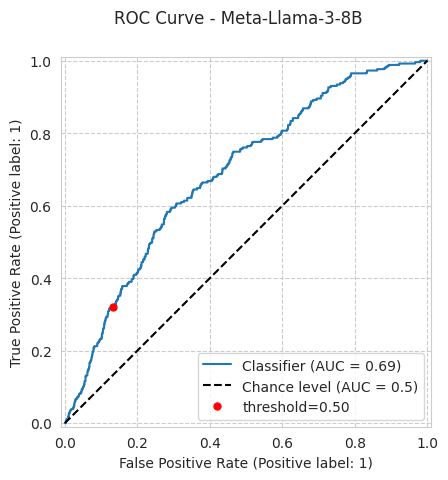

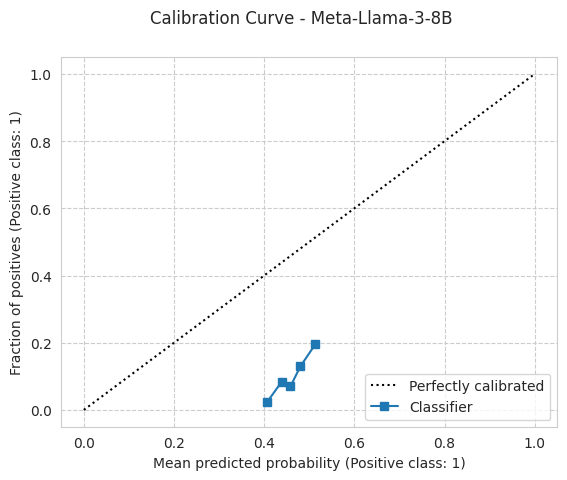

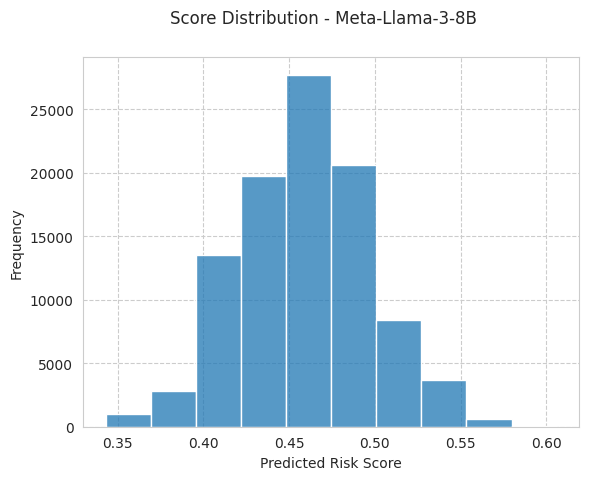

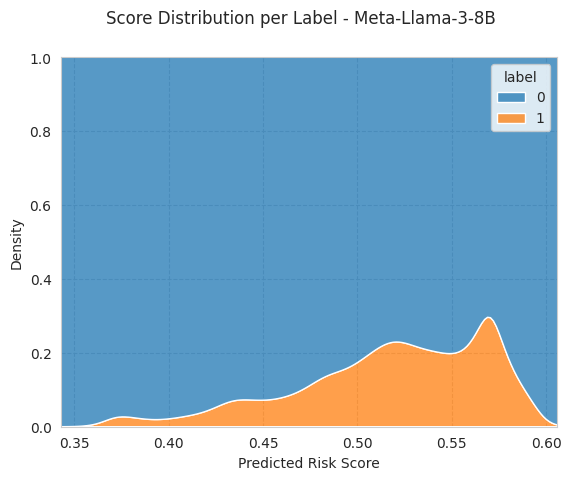

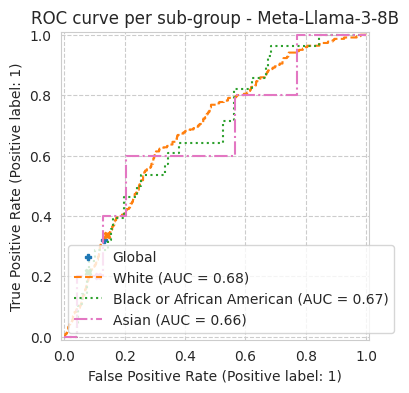

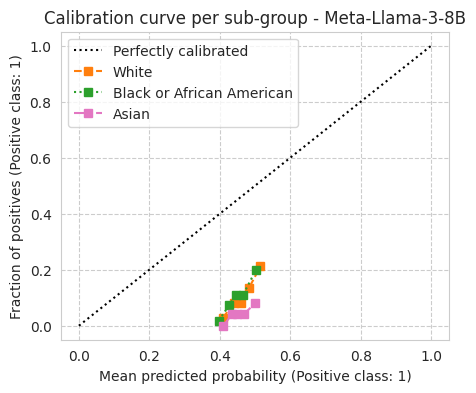

In [18]:
bench.plot_results();